from https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

In [1]:
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

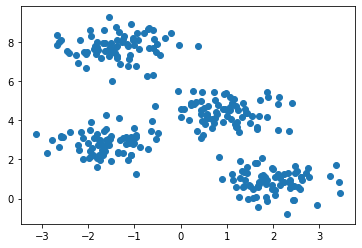

In [2]:
X, y = make_blobs(n_samples=300
                  , centers = 4
                  , cluster_std=0.6
                  , random_state = 0
                 )
plt.scatter(X[:, 0], X[:, 1]);

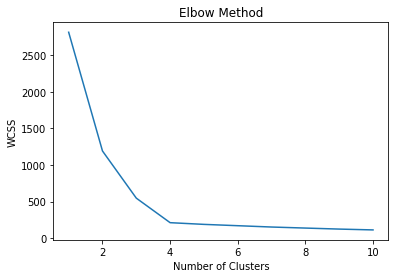

In [3]:
# within cluster sum of sqaures (WCSS) elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i
                    , init='k-means++'
                    , max_iter=300
                    , n_init=10
                    , random_state=0
                   )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS');

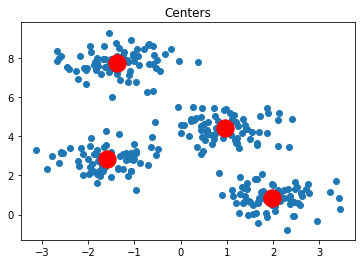

In [4]:
kmeans = KMeans(n_clusters=4
                , init='k-means++'
                , max_iter=300
                , n_init=10
                , random_state = 0
               )
pred_y = kmeans.fit_predict(X)

plt.scatter(X[:,0], X[:, 1])
plt.scatter(kmeans.cluster_centers_[:, 0]
            , kmeans.cluster_centers_[:, 1]
            , s=300
            , c='red'
           )
plt.title('Centers');

from https://medium.com/datadriveninvestor/kmeans-clustering-on-wearable-device-dataset-are-you-lying-sitting-or-running-ffe0637e7844

In [10]:
import os
from datetime import datetime as dt
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns
sns.set(style='whitegrid'
        , palette='muted'
        , font_scale=1.5
       )
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.width', 10000)
pd.set_option('display.precision', 6)
plt.rcParams['figure.figsize'] = [12, 6]

In [11]:
df = pd.read_csv('data/data_uci.csv')

In [12]:
if 'Unnamed: 0' in df.columns.tolist():
    df = df.drop(['Unnamed: 0'], axis=1)
if 'timestamp' in df.columns.tolist():
    df = df.drop(['timestamp'], axis=1)

df.head()

,activity,IMUhand4,IMUhand5,IMUhand6,IMUhand7,IMUhand8,IMUhand9,IMUhand10,IMUhand11,IMUhand12,IMUhand13,IMUhand14,IMUhand15,IMUhand16,IMUhand17,IMUhand18,IMUhand19,IMUhand20,IMUchest21,IMUchest22,IMUchest23,IMUchest24,IMUchest25,IMUchest26,IMUchest27,IMUchest28,IMUchest29,IMUchest30,IMUchest31,IMUchest32,IMUchest33,IMUchest34,IMUchest35,IMUchest36,IMUchest37,IMUankle38,IMUankle39,IMUankle40,IMUankle41,IMUankle42,IMUankle43,IMUankle44,IMUankle45,IMUankle46,IMUankle47,IMUankle48,IMUankle49,IMUankle50,IMUankle51,IMUankle52,IMUankle53,IMUankle54
0,1,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,1.0,0.0,0.0,0.0,32.1875,0.124482,9.65003,-1.65181,0.143941,9.71019,-1.47347,0.036668,0.016559,-0.052791,0.567566,-50.7269,44.2728,1.0,0.0,0.0,0.0,30.75,9.73855,-1.84761,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0
1,1,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,1.0,0.0,0.0,0.0,32.1875,0.200711,9.64980,-1.65043,0.129092,9.74041,-1.47329,0.019343,-0.024304,-0.059843,0.904990,-50.5080,43.5427,1.0,0.0,0.0,0.0,30.75,9.69762,-1.88438,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0
2,1,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,1.0,0.0,0.0,0.0,32.1875,0.270277,9.72331,-1.88174,0.144685,9.77048,-1.41285,-0.001428,0.038466,-0.046464,0.455480,-50.7209,44.0259,1.0,0.0,0.0,0.0,30.75,9.69633,-1.92203,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0
3,1,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,1.0,0.0,0.0,0.0,32.1875,0.236737,9.72447,-1.72746,0.174402,9.75538,-1.45841,0.017277,-0.048547,-0.074946,0.324284,-50.1544,43.6570,1.0,0.0,0.0,0.0,30.75,9.66370,-1.84714,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0
4,1,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,1.0,0.0,0.0,0.0,32.1875,0.352225,9.72437,-1.68665,0.173568,9.69512,-1.53414,0.000275,-0.013352,-0.039315,0.462317,-50.7110,42.9228,1.0,0.0,0.0,0.0,30.75,9.77578,-1.88582,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0


In [13]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 472576 entries, 0 to 472575
Data columns (total 52 columns):
activity      472576 non-null int64
IMUhand4      472576 non-null float64
IMUhand5      472576 non-null float64
IMUhand6      472576 non-null float64
IMUhand7      472576 non-null float64
IMUhand8      472576 non-null float64
IMUhand9      472576 non-null float64
IMUhand10     472576 non-null float64
IMUhand11     472576 non-null float64
IMUhand12     472576 non-null float64
IMUhand13     472576 non-null float64
IMUhand14     472576 non-null float64
IMUhand15     472576 non-null float64
IMUhand16     472576 non-null float64
IMUhand17     472576 non-null float64
IMUhand18     472576 non-null float64
IMUhand19     472576 non-null float64
IMUhand20     472576 non-null float64
IMUchest21    472576 non-null float64
IMUchest22    472576 non-null float64
IMUchest23    472576 non-null float64
IMUchest24    472576 non-null float64
IMUchest25    472576 non-null float64
IMUchest26  

In [16]:
df.activity.value_counts()

1    192290
2    184645
5    95641 
dtype: int64

1 = lying down
<br>

2 = sitting
<br>

5 = running

In [18]:
# Change 5 to 3 in activity

conditions = [df.activity==1
              , df.activity==2
              , df.activity==5
             ]
choices = [1, 2, 3]
df.activity = np.select(conditions, choices, default='null')

df['activity'].value_counts()

1    192290
2    184645
3    95641 
dtype: int64

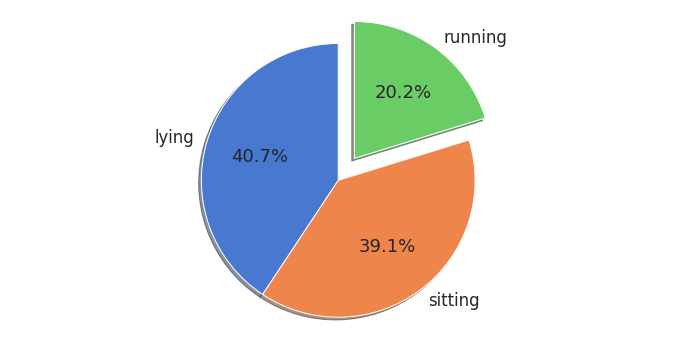

In [22]:
# pie chart of activities
labels = 'lying', 'sitting', 'running'
sizes = [192290, 184645, 95641]

# explode running
explode = (0, 0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(sizes
        , explode=explode
        , labels=labels
        , autopct = '%1.1f%%'
        , shadow=True
        , startangle=90
       )
ax1.axis('equal');


In [23]:
# IMU arms is IMUhand4-20
# IMU chest is IMUchest21-37
# IM ankle is IMUankle38-54